In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import mlflow
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [66]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [67]:
train.shape,test.shape

((10000, 12), (5000, 11))

In [68]:
print(train.head())
print(test.head())

        id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0    37295  Female   77                1         28.0                   0   
1  7185405  Female   42                1         39.0                   0   
2  9884048    Male   25                1         28.0                   0   
3  5891021  Female   61                1         28.0                   0   
4  9600579  Female   22                1         18.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         58876.0                 122.0       56   
1    1-2 Year            Yes         29238.0                  26.0      282   
2    < 1 Year             No         45944.0                 152.0      106   
3    1-2 Year             No          2630.0                 124.0       98   
4    < 1 Year             No         30643.0                 152.0      190   

   Response  
0         0  
1         1  
2         0  
3     

In [69]:
train_df = train.drop(columns=['id'])

In [70]:
train_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                10000 non-null  object 
 1   Age                   10000 non-null  int64  
 2   Driving_License       10000 non-null  int64  
 3   Region_Code           10000 non-null  float64
 4   Previously_Insured    10000 non-null  int64  
 5   Vehicle_Age           10000 non-null  object 
 6   Vehicle_Damage        10000 non-null  object 
 7   Annual_Premium        10000 non-null  float64
 8   Policy_Sales_Channel  10000 non-null  float64
 9   Vintage               10000 non-null  int64  
 10  Response              10000 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 859.5+ KB


In [71]:
train_df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [72]:
print(np.round(len(train_df[train_df['Response'] == 0])/len(train_df),2))
print(np.round(len(train_df[train_df['Response'] == 1])/len(train_df),2))

0.87
0.13


In [73]:
train_df.duplicated().sum()

np.int64(0)

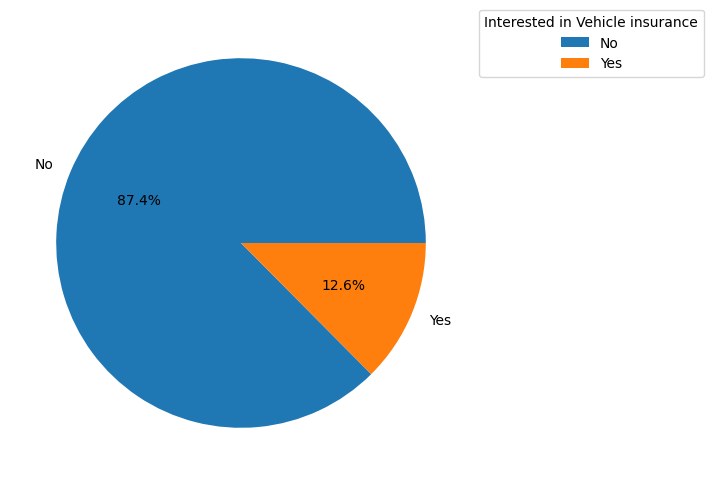

In [74]:
#Checking If training data is Imbalanced
response_data = train_df['Response'].value_counts()
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(response_data, labels = ["No","Yes"], autopct='%1.1f%%')
plt.legend(title = "Interested in Vehicle insurance",bbox_to_anchor=(1, 1.02))
plt.show()

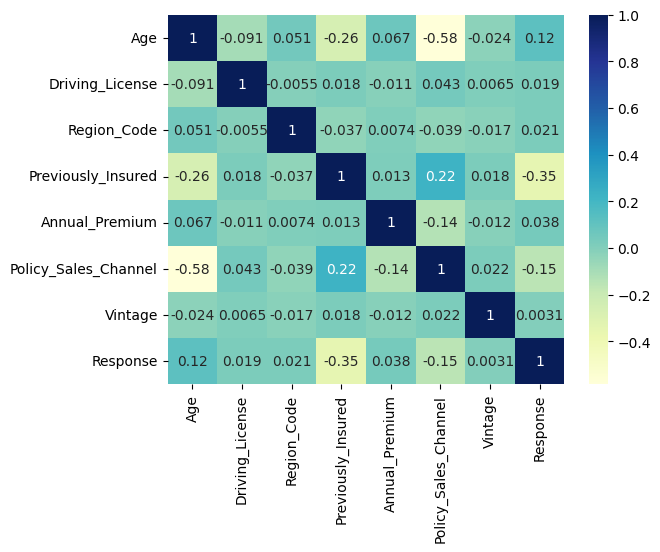

In [75]:
## Checking of correlation amoung variables
sns.heatmap(train_df.drop(columns=['Gender','Vehicle_Age','Vehicle_Damage']).corr(), cmap="YlGnBu", annot=True)
plt.show()

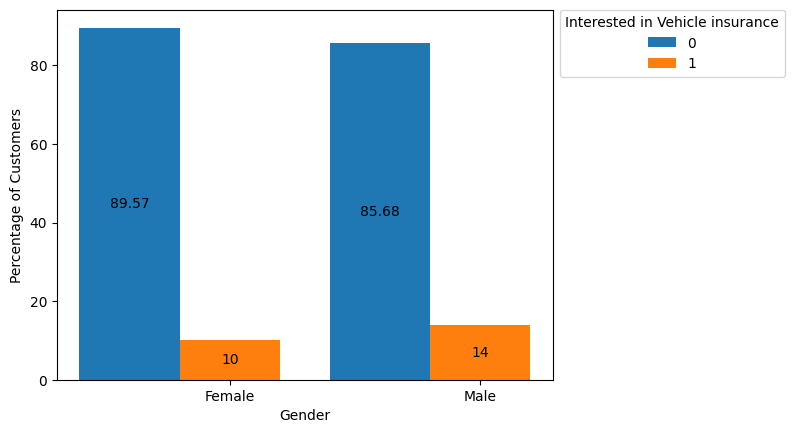

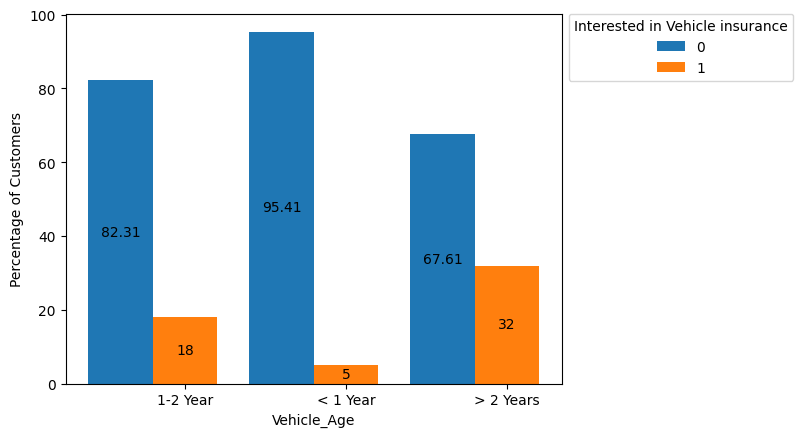

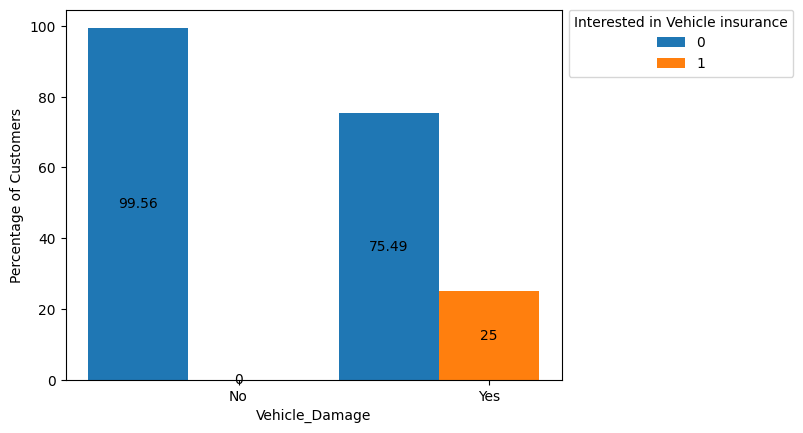

In [76]:
def plot_categorical_variables(train_df,column_name):
    crosstab = pd.crosstab(train_df[column_name],train_df['Response'])
    crosstab_index = crosstab.index
    crosstab_values = np.array([crosstab.values[i]/crosstab.values.sum(axis=1)[i] for i in range(0,len(crosstab))])
    crosstab_dict = {0:np.round(crosstab_values[:,0]*100,2),1:np.round(crosstab_values[:,1]*100)}
    fig, ax = plt.subplots()
    bottom = np.zeros(len(crosstab_index))
    width = 0.4
    x = np.arange(len(crosstab_index))
    for i,(Response, count_array) in enumerate(crosstab_dict.items()):
        offset = (i - len(crosstab_dict) / 2) * width
        p = ax.bar(x+offset, count_array, width, label=Response)
        bottom += count_array

        ax.bar_label(p, label_type='center')
    ax.set_xlabel(column_name)
    ax.set_ylabel("Percentage of Customers")
    ax.set_xticks(x)
    ax.set_xticklabels(crosstab_index)
    ax.legend(title='Interested in Vehicle insurance', bbox_to_anchor=(1, 1.02), 
            loc='upper left')

    plt.show()
categorical_lst = ['Gender','Vehicle_Age','Vehicle_Damage']
for category in categorical_lst:
    plot_categorical_variables(train_df,column_name=category)

In [77]:
train_df['Age'].max(),train_df['Age'].min(),train_df['Age'].mean()

(np.int64(81), np.int64(20), np.float64(38.4303))

In [78]:
print(len(train_df[(train_df['Age'] >= 0) & (train_df['Age'] < 25)]))
print(len(train_df[(train_df['Age'] >= 25) & (train_df['Age'] < 50)]))
print(len(train_df[(train_df['Age'] >= 50) & (train_df['Age'] < 75)]))
print(len(train_df[(train_df['Age'] >= 75) & (train_df['Age'] < 100)]))

2588
5039
2242
131


In [79]:
train_df['Age_group'] = ''
i = 0
cnt = 1
while(i<100):
    print(len(train_df[(train_df['Age'] >= i) & (train_df['Age'] < i+25)]))
    age_index = train_df[(train_df['Age'] >= i) & (train_df['Age'] < i+25)].index
    print(f"{cnt}")
    train_df.loc[age_index,'Age_group'] = cnt
    i+=25
    cnt+=1

2588
1
5039
2
2242
3
131
4


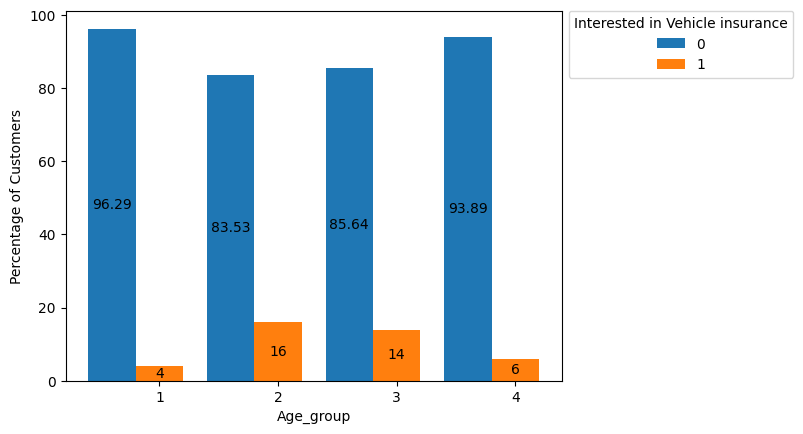

In [80]:
plot_categorical_variables(train_df,column_name='Age_group')

In [81]:
train_df = train_df.drop(columns=['Age','Gender','Region_Code'])

In [82]:
vehicle_damage_index = train_df[train_df['Vehicle_Damage'] == 'Yes'].index
vehicle_not_damage_index = train_df[train_df['Vehicle_Damage'] == 'No'].index
train_df.loc[vehicle_damage_index,'Vehicle_Damage'] = 1
train_df.loc[vehicle_not_damage_index,'Vehicle_Damage'] = 0
train_df

,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_group
0,1,0,1-2 Year,1,58876.0,122.0,56,0,4
1,1,0,1-2 Year,1,29238.0,26.0,282,1,2
2,1,0,< 1 Year,0,45944.0,152.0,106,0,2
3,1,0,1-2 Year,0,2630.0,124.0,98,0,3
4,1,1,< 1 Year,0,30643.0,152.0,190,0,1
...,...,...,...,...,...,...,...,...,...
9995,1,1,1-2 Year,0,34854.0,26.0,52,0,3
9996,1,1,< 1 Year,0,25016.0,152.0,253,0,2
9997,1,1,1-2 Year,0,32323.0,139.0,60,0,3
9998,1,1,< 1 Year,0,37011.0,152.0,56,0,2


In [83]:
vehicle_age_0_index = train_df[train_df['Vehicle_Age'] == '< 1 Year'].index
vehicle_age_1_index = train_df[train_df['Vehicle_Age'] == '1-2 Year'].index
vehicle_age_2_index = train_df[train_df['Vehicle_Age'] == '> 2 Years'].index
train_df.loc[vehicle_age_0_index,'Vehicle_Age'] = 0
train_df.loc[vehicle_age_1_index,'Vehicle_Age'] = 1
train_df.loc[vehicle_age_2_index,'Vehicle_Age'] = 2


In [84]:
train_df

,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_group
0,1,0,1,1,58876.0,122.0,56,0,4
1,1,0,1,1,29238.0,26.0,282,1,2
2,1,0,0,0,45944.0,152.0,106,0,2
3,1,0,1,0,2630.0,124.0,98,0,3
4,1,1,0,0,30643.0,152.0,190,0,1
...,...,...,...,...,...,...,...,...,...
9995,1,1,1,0,34854.0,26.0,52,0,3
9996,1,1,0,0,25016.0,152.0,253,0,2
9997,1,1,1,0,32323.0,139.0,60,0,3
9998,1,1,0,0,37011.0,152.0,56,0,2


In [85]:
train_df[['Vehicle_Age','Vehicle_Damage','Age_group']] = train_df[['Vehicle_Age','Vehicle_Damage','Age_group']].astype('int64')

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driving_License       10000 non-null  int64  
 1   Previously_Insured    10000 non-null  int64  
 2   Vehicle_Age           10000 non-null  int64  
 3   Vehicle_Damage        10000 non-null  int64  
 4   Annual_Premium        10000 non-null  float64
 5   Policy_Sales_Channel  10000 non-null  float64
 6   Vintage               10000 non-null  int64  
 7   Response              10000 non-null  int64  
 8   Age_group             10000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 703.3 KB


In [87]:
X = train_df.drop(columns=['Response'])
Y = train_df['Response']
X.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_') for col in X.columns]
print(X.shape,Y.shape)

(10000, 8) (10000,)


In [88]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=40)

print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(7500, 8) (7500,) (2500, 8) (2500,)


In [89]:
mlflow.set_experiment("First Experiment")
mlflow.set_tracking_uri(uri="http://192.168.0.190:8080/")

2025/01/09 17:40:51 INFO mlflow.tracking.fluent: Experiment with name 'First Experiment' does not exist. Creating a new experiment.


In [90]:
train_df.to_csv('train_df.csv',index=False)

In [91]:

lr = LogisticRegression(n_jobs=-1)
lr_model = lr.fit(X_train,Y_train)
x_train_pred = lr_model.predict(X_train) 
x_test_pred = lr_model.predict(X_test)

train_accuracy = round(accuracy_score(Y_train,x_train_pred)*100,2)
test_accuracy = round(accuracy_score(Y_test,x_test_pred)*100,2)

params = {'default':"default"}
dataset =  mlflow.data.from_pandas(
    train_df, source=r"D:\ML Flow\train_df.csv",name="Kaggle Competition", targets="Response"
)

with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_input(dataset, context="training")
    mlflow.log_params(params)
    mlflow.log_metrics({
            'train_accuracy': train_accuracy,
            'test_accuracy' : test_accuracy,
        })
    mlflow.sklearn.log_model(lr, "Logistic Regression") 


2025/01/09 17:40:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://192.168.0.190:8080/#/experiments/569486006668135596/runs/7c631b2124214e6ab4ee2059538c24e6
🧪 View experiment at: http://192.168.0.190:8080/#/experiments/569486006668135596


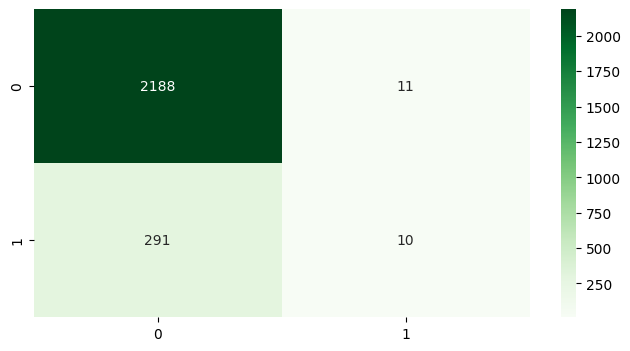

In [92]:

cm = confusion_matrix(Y_test,x_test_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
plt.show()

In [93]:
x_test_pred = lr_model.predict_proba(X_test)


In [94]:
x_test_pred

array([[0.75047264, 0.24952736],
       [0.99609569, 0.00390431],
       [0.99769044, 0.00230956],
       ...,
       [0.59036594, 0.40963406],
       [0.99593199, 0.00406801],
       [0.72088811, 0.27911189]], shape=(2500, 2))

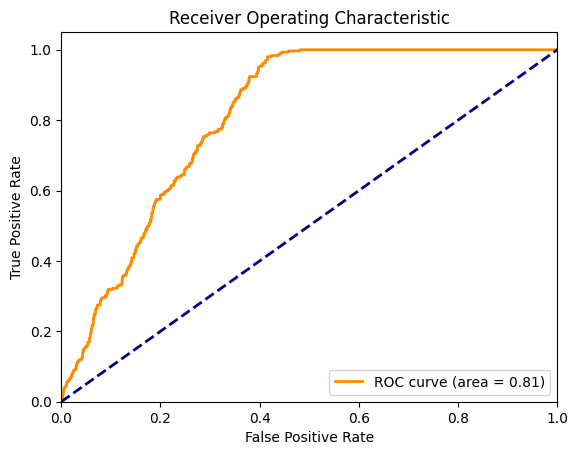

In [95]:

fpr, tpr, thresholds = roc_curve(Y_test, x_test_pred[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

2025/01/09 17:40:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://192.168.0.190:8080/#/experiments/569486006668135596/runs/6bc3691769ce41afa2cb5295559fee57
🧪 View experiment at: http://192.168.0.190:8080/#/experiments/569486006668135596
Training Accuracy  87.27
Test accuracy  87.96


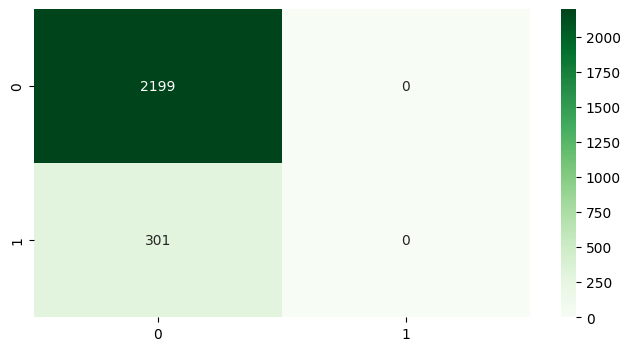

In [96]:

params = {"n_estimators" : 100,
          "max_depth" : 4,
          "n_jobs" : -1}
rfc = RandomForestClassifier(**params)

rfc_model = rfc.fit(X_train,Y_train)
x_train_pred = rfc_model.predict(X_train) 
x_test_pred = rfc_model.predict(X_test)

train_accuracy = round(accuracy_score(Y_train,x_train_pred)*100,2)
test_accuracy = round(accuracy_score(Y_test,x_test_pred)*100,2)


with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_input(dataset, context="training")
    mlflow.log_params(params)
    mlflow.log_metrics({
            'train_accuracy': train_accuracy,
            'test_accuracy' : test_accuracy,
        })
    mlflow.sklearn.log_model(rfc_model, "Random Forest") 

print("Training Accuracy ",train_accuracy)
print("Test accuracy ",test_accuracy)

cm = confusion_matrix(Y_test,x_test_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
plt.show()


[17:40:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




2025/01/09 17:40:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB Classifier at: http://192.168.0.190:8080/#/experiments/569486006668135596/runs/464aa5c2fe2f4446aa1714250e47cc67
🧪 View experiment at: http://192.168.0.190:8080/#/experiments/569486006668135596
Training Accuracy  94.61
Test accuracy  86.0


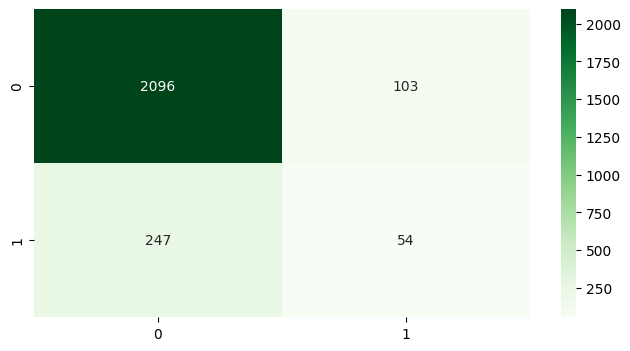

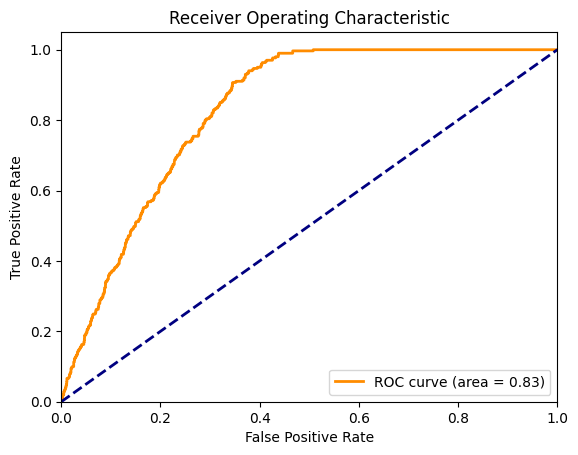

In [97]:
params = {
    "n_estimators" : 100,
    "learning_rate" : 0.5,
    "subsample" : 0.8,
    "max_depth" : 5,
    "n_jobs" : -1,
    "device" : "cuda"
    }

xgb = XGBClassifier(**params)
xgb_model = xgb.fit(X_train, Y_train)
x_train_pred = xgb_model.predict(X_train) 
x_test_pred = xgb_model.predict(X_test)

train_accuracy = accuracy_score(Y_train,x_train_pred)*100
test_accuracy = accuracy_score(Y_test,x_test_pred)*100

with mlflow.start_run(run_name="XGB Classifier"):
    mlflow.log_input(dataset, context="training")
    mlflow.log_params(params)
    mlflow.log_metrics({
            'train_accuracy': train_accuracy,
            'test_accuracy' : test_accuracy,
        })
    mlflow.xgboost.log_model(xgb_model, "XGB Classifier") 

print("Training Accuracy ",np.round(train_accuracy,2))
print("Test accuracy ",np.round(test_accuracy,2))

cm = confusion_matrix(Y_test,x_test_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
plt.show()

x_test_pred = xgb_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, x_test_pred[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

[17:40:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




2025/01/09 17:41:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB Classifier at: http://192.168.0.190:8080/#/experiments/569486006668135596/runs/8ee9f6c3f5ae4bfca9663600a27a7a00
🧪 View experiment at: http://192.168.0.190:8080/#/experiments/569486006668135596
Training Accuracy  99.79
Test accuracy  84.96


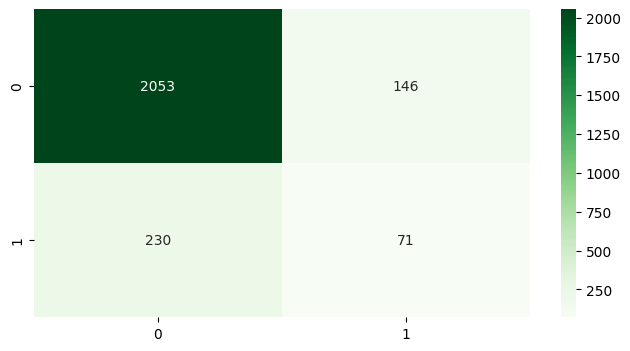

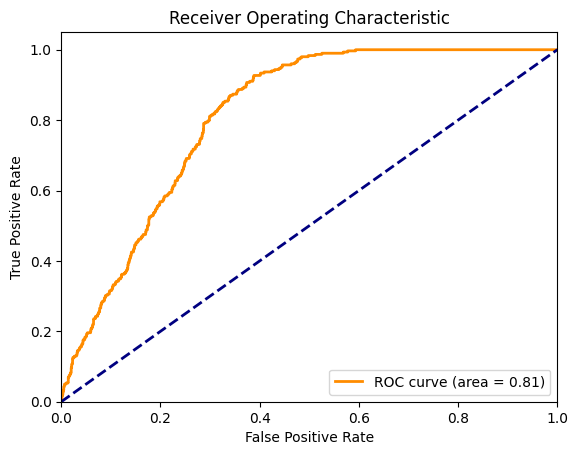

In [98]:
params = {
    "n_estimators" : 500,
    "learning_rate" : 0.5,
    "subsample" : 0.8,
    "max_depth" : 5,
    "n_jobs" : -1,
    "device" : "cuda"
    }

xgb = XGBClassifier(**params)
xgb_model = xgb.fit(X_train, Y_train)
x_train_pred = xgb_model.predict(X_train) 
x_test_pred = xgb_model.predict(X_test)

train_accuracy = accuracy_score(Y_train,x_train_pred)*100
test_accuracy = accuracy_score(Y_test,x_test_pred)*100

with mlflow.start_run(run_name="XGB Classifier"):
    mlflow.log_input(dataset, context="training")
    mlflow.log_params(params)
    mlflow.log_metrics({
            'train_accuracy': train_accuracy,
            'test_accuracy' : test_accuracy,
        })
    mlflow.xgboost.log_model(xgb_model, "XGB Classifier") 

print("Training Accuracy ",np.round(train_accuracy,2))
print("Test accuracy ",np.round(test_accuracy,2))

cm = confusion_matrix(Y_test,x_test_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
plt.show()

x_test_pred = xgb_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, x_test_pred[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

[17:41:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




2025/01/09 17:41:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB Classifier at: http://192.168.0.190:8080/#/experiments/569486006668135596/runs/91e3328f0150425f8bf11727d8766bc5
🧪 View experiment at: http://192.168.0.190:8080/#/experiments/569486006668135596
Training Accuracy  99.84
Test accuracy  84.56


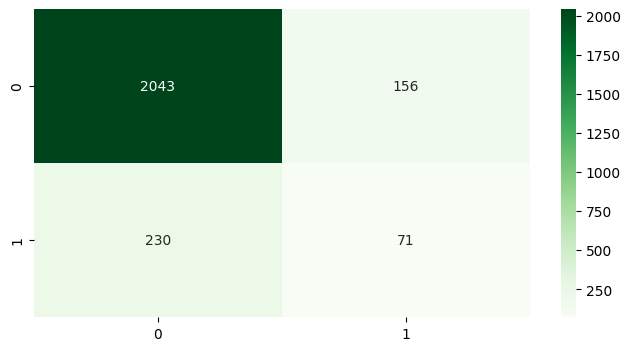

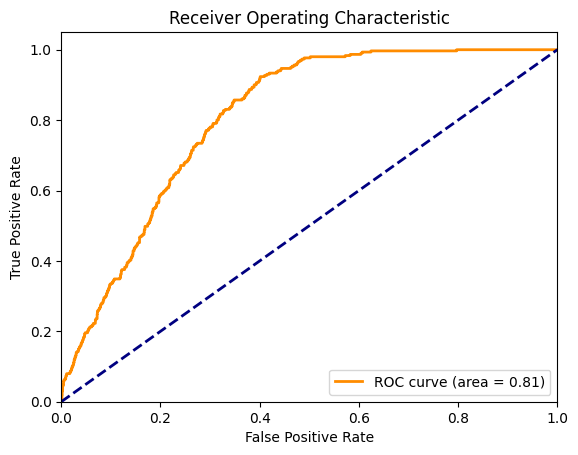

In [99]:
params = {
    "n_estimators" : 1000,
    "learning_rate" : 0.5,
    "subsample" : 0.8,
    "max_depth" : 5,
    "n_jobs" : -1,
    "device" : "cuda"
    }

xgb = XGBClassifier(**params)
xgb_model = xgb.fit(X_train, Y_train)
x_train_pred = xgb_model.predict(X_train) 
x_test_pred = xgb_model.predict(X_test)

train_accuracy = accuracy_score(Y_train,x_train_pred)*100
test_accuracy = accuracy_score(Y_test,x_test_pred)*100

with mlflow.start_run(run_name="XGB Classifier"):
    mlflow.log_input(dataset, context="training")
    mlflow.log_params(params)
    mlflow.log_metrics({
            'train_accuracy': train_accuracy,
            'test_accuracy' : test_accuracy,
        })
    mlflow.xgboost.log_model(xgb_model, "XGB Classifier") 

print("Training Accuracy ",np.round(train_accuracy,2))
print("Test accuracy ",np.round(test_accuracy,2))

cm = confusion_matrix(Y_test,x_test_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="Greens")
plt.show()

x_test_pred = xgb_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, x_test_pred[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()